## Temporal Autocorrelation

Buoy data download:
```
http://buoybay.noaa.gov/sites/default/files/data-reports/process-reports.php?station%5B%5D=GR&year%5B%5D=2007&year%5B%5D=2008&year%5B%5D=2009&year%5B%5D=2010&year%5B%5D=2011&year%5B%5D=2012&year%5B%5D=2013&year%5B%5D=2014&year%5B%5D=2015&year%5B%5D=2016&year%5B%5D=2017&year%5B%5D=2018&year%5B%5D=2019&year%5B%5D=2020&year%5B%5D=2021&year%5B%5D=2022&year%5B%5D=2023&year%5B%5D=2024&type%5B%5D=ocean&
```

Goose's Reef through CBIBS.

- Website: https://buoybay.noaa.gov/data/data-download
- [Meaning of QC flags](https://buoybay.noaa.gov/sites/default/files/2023-02/CBIBSQCCodeMeanings_2.pdf) for CBIBS data

In [1]:
import os

import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
REPO_ROOT = '/Users/rwegener/repos/chesapeake_mhw'

### Reading and cleaning data

* GR = Goose's Reef (3532 days of data ~10 years from Apr 2011-Mar 2024)
* SR = Stingray Point (3107 days of data ~8.5 years from Jun 2012-Mar 2024)
* AN = Annapolis (2308 days of data ~6 years from Sept 2013-Mar 2024)
* YS = York Split


Also tried:
* SN = Patapsco (not enough data, only 640 days ~2 years)

In [4]:
buoy_filepath = os.path.join(REPO_ROOT, 'data/raw', 'GR_OCEAN_2007-2024.csv')
# buoy_filepath = os.path.join(REPO_ROOT, 'data/raw', 'SR_OCEAN_2007-2024.csv')
# buoy_filepath = os.path.join(REPO_ROOT, 'data/raw', 'AN_OCEAN_2007-2024.csv')

# Not using
# buoy_filepath = os.path.join(REPO_ROOT, 'data/raw', 'SN_OCEAN_2007-2024.csv')
# buoy_filepath = os.path.join(REPO_ROOT, 'data/raw', 'YS_OCEAN_2007-2024.csv')

In [5]:
buoy = pd.read_csv(
    buoy_filepath, 
    usecols=['Time (UTC)', 'Temperature QC', 'Temperature'],
)

/var/folders/p8/985fq4dx1356qtcv5dd4zgyr0000gn/T/ipykernel_5760/704043643.py:1: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  buoy = pd.read_csv(


In [6]:
# Remove unit rows
buoy = buoy.drop([0, 1])
# Remove any data that is bad, questionable, or missing
buoy = buoy[buoy['Temperature QC'].isin([1, 2])]

In [7]:
buoy['datetime'] = pd.to_datetime(buoy['Time (UTC)'])

In [8]:
# Make datetime timezone aware
buoy.datetime = buoy.datetime.dt.tz_localize('UTC')
# Convert to eastern time
buoy.datetime = buoy.datetime.dt.tz_convert('America/New_York')

In [9]:
# An additional QC since some measurements with QC flag of 2 have very high values
buoy.loc[buoy.Temperature > 40] = None

## Buoy-based Satellite anomaly calculation

### Subset to nighttime and take mean for daily value

Time is UTC.

In [10]:
# filter to just obserations between midnight and 7am local time
buoy_night = buoy[buoy.datetime.dt.hour.isin(range(0, 7))] 

<Axes: xlabel='datetime', ylabel='Temperature'>

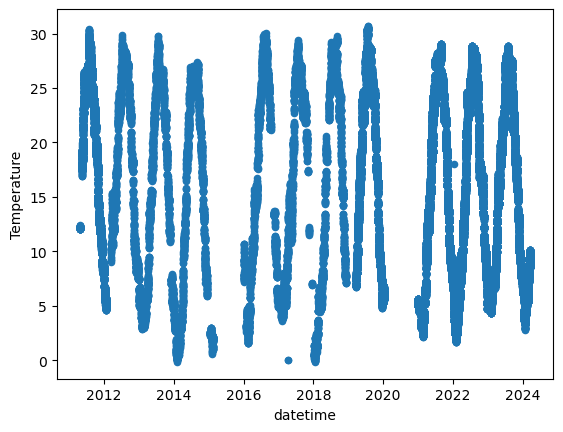

In [11]:
buoy_night.plot.scatter('datetime', 'Temperature')

In [12]:
# take average for each day
buoy_daily = buoy_night.groupby(buoy_night.datetime.dt.date).Temperature.mean()


In [13]:
buoy_daily.index = pd.to_datetime(buoy_daily.index)

### Back to normal

In [14]:
# resample to ensure daily observations
# buoy_daily.index = pd.to_datetime(buoy_daily.index)
# buoy_daily = buoy_daily.resample('D').ffill() 

In [15]:
daily = pd.date_range(buoy_daily.index[0], buoy_daily.index[-1], freq='D')
buoy_daily = buoy_daily.reindex(daily, fill_value=np.NaN)

In [16]:
buoy_daily.index.name = 'datetime'

### Match satellite data with buoy data

In [17]:
geopolar_path = os.path.join(
    REPO_ROOT,
    'data/raw',
    'L4_GHRSST-SSTfnd-Geo_Polar_Blended_Night-GLOB-v02.0-fv01.0_CB_20020901_20230831.nc'
)

In [18]:
geopolar = xr.open_dataset(
    geopolar_path, 
    drop_variables=['analysis_error', 'sea_ice_fraction', 'mask']
)

In [19]:
geopolar = geopolar - 273

In [20]:
# Goose Reef lat/lon
lat_gr = 38.556
lon_gr = -76.415

In [21]:
# Stingray Point lat/lon
# lat_gr = 37.567
# lon_gr = -76.262

In [22]:
# # Patapsco lat/lon
# lat_gr = 39.152
# lon_gr = -76.391

In [23]:
# Annapolis lat/lon
# lat_gr = 38.964
# lon_gr = -76.447

In [24]:
geopolar_gr = geopolar.sel(lat=lat_gr, lon=lon_gr, method='nearest')

In [25]:
# convert to dataframe
geopolar_df = geopolar_gr.to_dataframe()
# clean
geopolar_df = geopolar_df.drop(['lat', 'lon'], axis=1)
geopolar_df = geopolar_df.reset_index()

In [26]:
# create a date column
geopolar_df['date'] = pd.to_datetime(geopolar_df.time.dt.date)

In [27]:
# geopolar_df = geopolar_df.set_index('date')

In [28]:
# geopolar_df

In [29]:
# buoy_daily.groupby(buoy_daily.index.date).mean()

Merge the geopolar dataframe with the buoy data to create a new dataframe with all the data in the same dataframe

In [30]:
observed_temps = geopolar_df.merge(buoy_daily, how='inner', left_on='date', right_on='datetime')

In [31]:
# cleaning
# rename columns
observed_temps = observed_temps.rename(
    {'analysed_sst': 'geopolar_sst',
     'Temperature': 'goosereef_sst',
    },
    axis=1,
)
# drop un-needed columns
observed_temps = observed_temps.drop('time', axis=1)
# set date as index and convert to datetime
observed_temps = observed_temps.set_index(pd.to_datetime(observed_temps.date))
# remove the one duplicate row
observed_temps = observed_temps[~observed_temps.index.duplicated()]
# resample to ensure daily observations
observed_temps = observed_temps.resample('D').ffill() 
# drop un-needed columns
observed_temps = observed_temps.drop('date', axis=1)

<Axes: xlabel='date'>

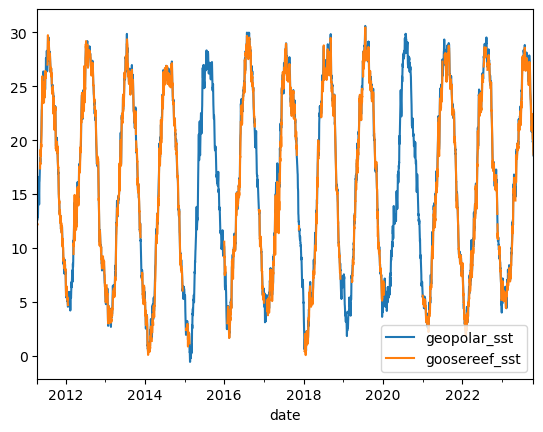

In [32]:
observed_temps[['geopolar_sst', 'goosereef_sst']].plot()

### Remove climatology

In [33]:
observed_temps['month'] = observed_temps.index.month
observed_temps['day'] = observed_temps.index.day

In [34]:
clim_geo = observed_temps.geopolar_sst.groupby([observed_temps.month, observed_temps.day]).mean()


In [35]:
clim_geo = clim_geo.reset_index()

In [36]:
clim_geo = clim_geo.rename({'geopolar_sst': 'geopolar_clim'}, axis=1)

In [37]:
clim_geo

,month,day,geopolar_clim
0,1,1,6.410828
1,1,2,6.275826
2,1,3,5.932495
3,1,4,5.763326
4,1,5,5.723325
...,...,...,...
361,12,27,6.571661
362,12,28,6.649162
363,12,29,6.564161
364,12,30,6.451660


In [38]:
# clim_geo.index = clim_geo.index.set_names(['month', 'day'])

In [39]:
# clim_geo['year'] = 2000

In [40]:
# pd.to_datetime([clim_geo.year, clim_geo.month, clim_geo.day])
# clim_geo['date'] = pd.to_datetime(clim_geo[['year', 'month', 'day']])

Goose Reef

In [41]:
clim_goose = observed_temps.goosereef_sst.groupby([observed_temps.month, observed_temps.day]).mean()


In [42]:
clim_goose = clim_goose.reset_index()

In [43]:
clim_goose = clim_goose.rename({'goosereef_sst': 'goosereef_clim'}, axis=1)

In [44]:
clim_goose

,month,day,goosereef_clim
0,1,1,6.905455
1,1,2,6.799987
2,1,3,6.708560
3,1,4,6.345636
4,1,5,6.129985
...,...,...,...
361,12,27,6.638906
362,12,28,6.537579
363,12,29,6.185957
364,12,30,6.209524


In [45]:
observed_temps['year'] = observed_temps.index.year

In [46]:
observed_temps

,geopolar_sst,goosereef_sst,month,day,year
date,,,,,
2011-04-18,12.639984,12.181429,4,18,2011
2011-04-19,12.679993,12.183590,4,19,2011
2011-04-20,12.910004,NaN,4,20,2011
2011-04-21,12.979980,NaN,4,21,2011
2011-04-22,12.880005,NaN,4,22,2011
...,...,...,...,...,...
2023-10-13,19.759979,20.241000,10,13,2023
2023-10-14,19.690002,19.879286,10,14,2023
2023-10-15,19.089996,19.284000,10,15,2023


Merge

In [47]:
observed_temps = observed_temps.merge(clim_geo, how='left', on=['month', 'day'])

In [48]:
observed_temps['geopolar_anom'] = observed_temps.geopolar_sst - observed_temps.geopolar_clim

In [49]:
observed_temps

,geopolar_sst,goosereef_sst,month,day,year,geopolar_clim,geopolar_anom
0,12.639984,12.181429,4,18,2011,13.096145,-0.456161
1,12.679993,12.183590,4,19,2011,13.217684,-0.537691
2,12.910004,NaN,4,20,2011,13.418452,-0.508449
3,12.979980,NaN,4,21,2011,13.669990,-0.690009
4,12.880005,NaN,4,22,2011,13.839996,-0.959991
...,...,...,...,...,...,...,...
4561,19.759979,20.241000,10,13,2023,20.025381,-0.265402
4562,19.690002,19.879286,10,14,2023,19.964603,-0.274601
4563,19.089996,19.284000,10,15,2023,19.832302,-0.742306
4564,19.009979,18.930857,10,16,2023,19.737688,-0.727709


Next Merge

In [50]:
observed_temps = observed_temps.merge(clim_goose, how='left', on=['month', 'day'])

In [51]:
observed_temps['goosereef_anom'] = observed_temps.goosereef_sst - observed_temps.goosereef_clim


In [52]:
observed_temps['date'] = pd.to_datetime(observed_temps[['year', 'month', 'day']])

In [53]:
observed_temps = observed_temps.set_index('date')

Text(0, 0.5, 'SST Anomaly from Climatology (degrees C)')

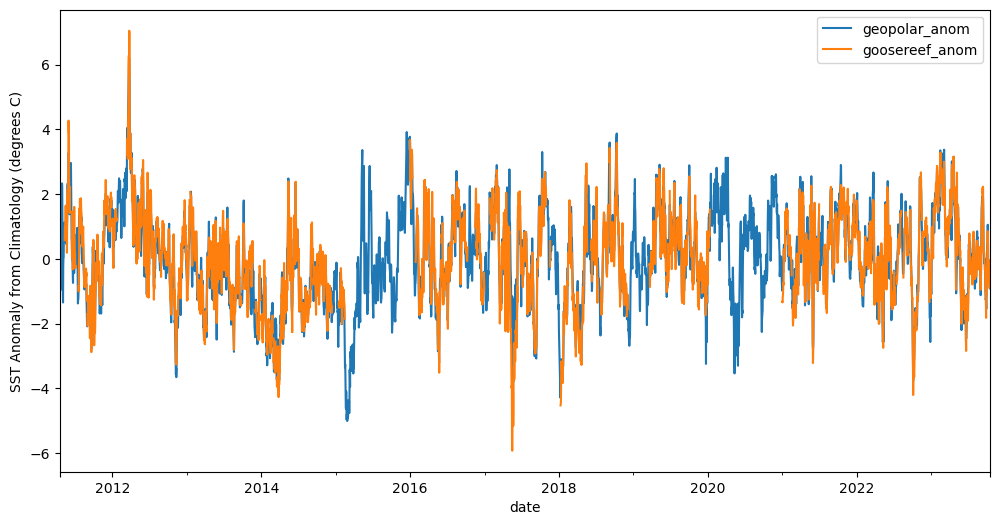

In [54]:
observed_temps[['geopolar_anom', 'goosereef_anom']].plot(figsize=(12, 6))

plt.ylabel('SST Anomaly from Climatology (degrees C)')


<Axes: xlabel='date'>

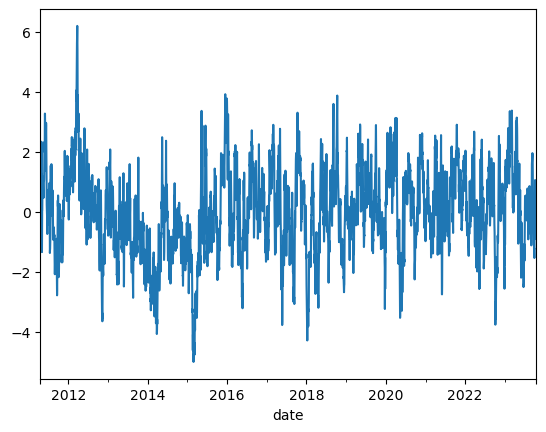

In [55]:
observed_temps.geopolar_anom.plot()

<Axes: xlabel='date'>

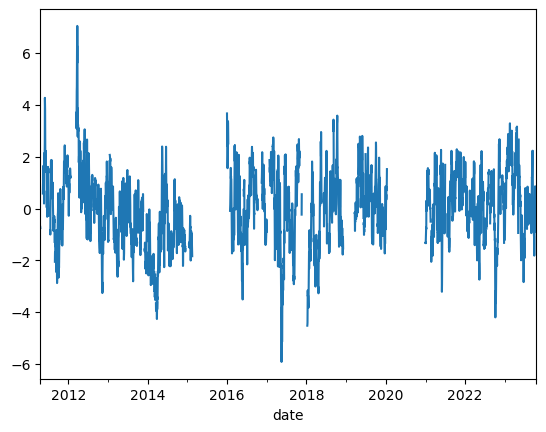

In [56]:
observed_temps.goosereef_anom.plot()

### Calculate anomaly

In [57]:
# observed_temps['geopolar_anom'] = observed_temps.geopolar_sst - observed_temps.goosereef_sst


In [58]:
# observed_temps.geopolar_anom.plot()

In [59]:
observed_temps['anom_error'] = observed_temps.geopolar_anom - observed_temps.goosereef_anom

**Idea: create hexplot similar to the one from the paper?**

Text(0, 0.5, 'geopolar_anom - goosereef_anom (degrees C)')

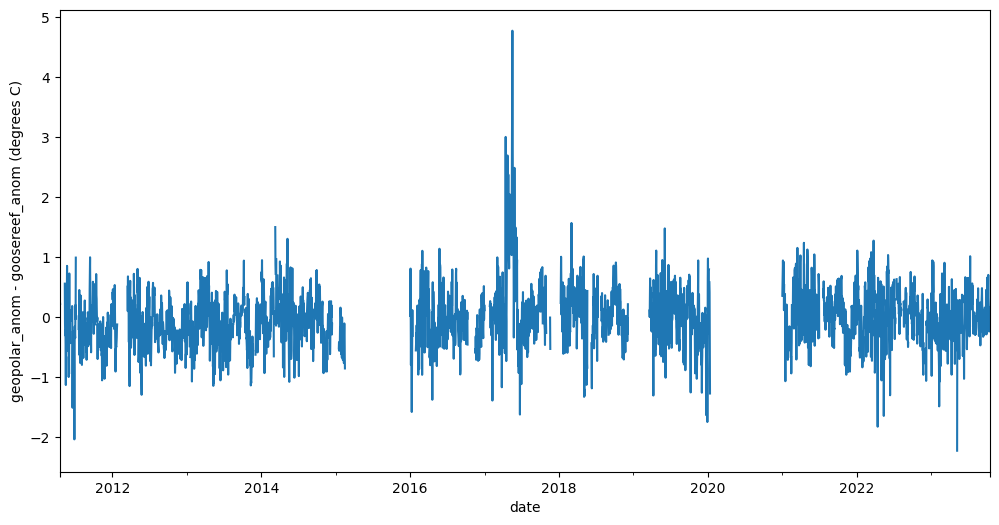

In [60]:
observed_temps.anom_error.plot(figsize=(12, 6))

plt.ylabel('geopolar_anom - goosereef_anom (degrees C)')

## Temporal Autocorrelation calculation

[https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.acf.html](https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.acf.html)

In [61]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [62]:
# nans are dropped in computation 
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html
acf = sm.tsa.acf(observed_temps.anom_error, missing='drop')  # , nlags=400)

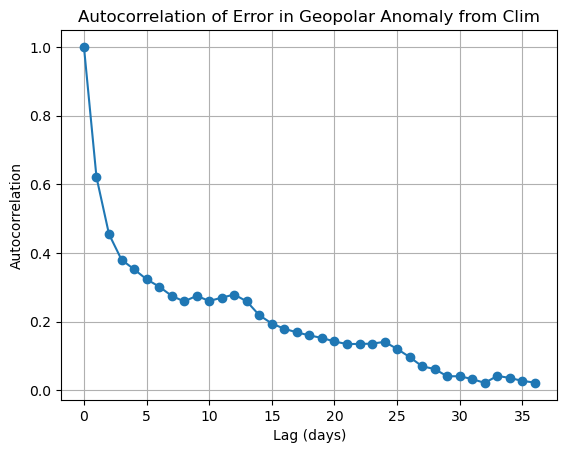

In [63]:
plt.plot(acf, marker='o')
plt.title('Autocorrelation of Error in Geopolar Anomaly from Clim')
plt.xlabel('Lag (days)')
plt.ylabel('Autocorrelation')

plt.grid()

### Decorrelation Timescale

In [64]:
1/np.e

0.36787944117144233

In [65]:
for index, value in enumerate(acf):
    if value < 1/np.e:
        print('First index below 1/e is:', index)
        break

First index below 1/e is: 4


In [66]:
acf

array([1.        , 0.62058056, 0.45456914, 0.38008021, 0.35220335,
       0.32311574, 0.30180357, 0.27496753, 0.25849342, 0.27492753,
       0.25985766, 0.26948809, 0.27870503, 0.25863433, 0.2183226 ,
       0.19424016, 0.1788028 , 0.16844513, 0.15956395, 0.15217702,
       0.14183938, 0.13437718, 0.13477543, 0.13549882, 0.14084651,
       0.12026995, 0.0965493 , 0.06952823, 0.06162536, 0.0404916 ,
       0.04065475, 0.0323413 , 0.02115352, 0.0417508 , 0.03561474,
       0.02704647, 0.02208011])